Analyze how covariate matching changes when we use propensity matching in the GAN latent space.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
pd.set_option('mode.chained_assignment', None)
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matching
from config import *
from style import cb, cr
import data
import util
import viz

# df contains filenames, ids, and attributes
df = data.load_all_labs()
df = df.set_index('fname_id')

# add Race = Black
k_group = 'gender'
df['Race=Black'] = 0
df.loc[df['race4_pred'] == 'Black', 'Race=Black'] = 1

# fit propensity scores
**matching code based on [here](https://nbviewer.jupyter.org/github/kellieotto/StatMoments/blob/master/PSM.ipynb)**

In [2]:
# read in all the latents
fname_nps = [f for f in sorted(os.listdir(DIR_GEN)) if 'npy' in f] # these start at 00001
latents = np.array([np.load(oj(DIR_GEN, f))
                    for f in fname_nps]).mean(axis=1) # restricted style space
assert latents.shape == (30000, 512), 'Must download latents from gdrive folder to rerun this analysis!'

Accuracy 0.9807
CV Accuracy 0.9715


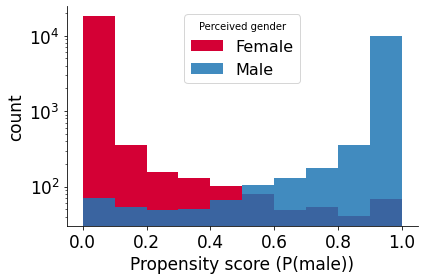

In [43]:
# fit and caclulate the propensity scores
lm = LogisticRegression(random_state=42)
lm = lm.fit(latents, df['gender']) #data[names[1:-1]], data.Treated)
print('Accuracy', lm.score(latents, df['gender']).round(4))
print('CV Accuracy',
      np.mean(cross_val_score(LogisticRegression(random_state=42),
                              latents, df['gender'].values)).round(4))
pscores = lm.predict_proba(latents)[:, 1] # The predicted propensities by the model
df['pscores'] = pscores

# plot
plt.hist(pscores[df['gender'] == 0], label='Female', color=cr)
plt.hist(pscores[df['gender'] == 1], label='Male', alpha=0.85, color=cb)
plt.xlabel('Propensity score (P(male))')
plt.ylabel('count')
plt.yscale('log')
plt.legend(title='Perceived gender')
util.savefig('scores_propensity')
plt.show()

In [44]:
d = df.reset_index()
# caliper: how close matches need to be
matches1, matches2 = matching.calc_propensity_matches(d['gender'], d['pscores'], caliper=0.1)
pkl.dump({'matches1': matches1, 'matches2': matches2},
         open(oj(DIR_PROCESSED, 'matches_propensity_caliper=0.1_matches=605.pkl'), 'wb'))

100%|██████████| 10916/10916 [00:07<00:00, 1481.97it/s]


In [3]:
matches = pkl.load(open(oj(DIR_PROCESSED, 'matches_propensity_caliper=0.1_matches=605.pkl'),
                        'rb'))
df_matched = df.reset_index().loc[matches['matches1'] + matches['matches2']]

print('num matches', df_matched['gender'].shape[0] // 2)

num matches 605


# mean diff checking

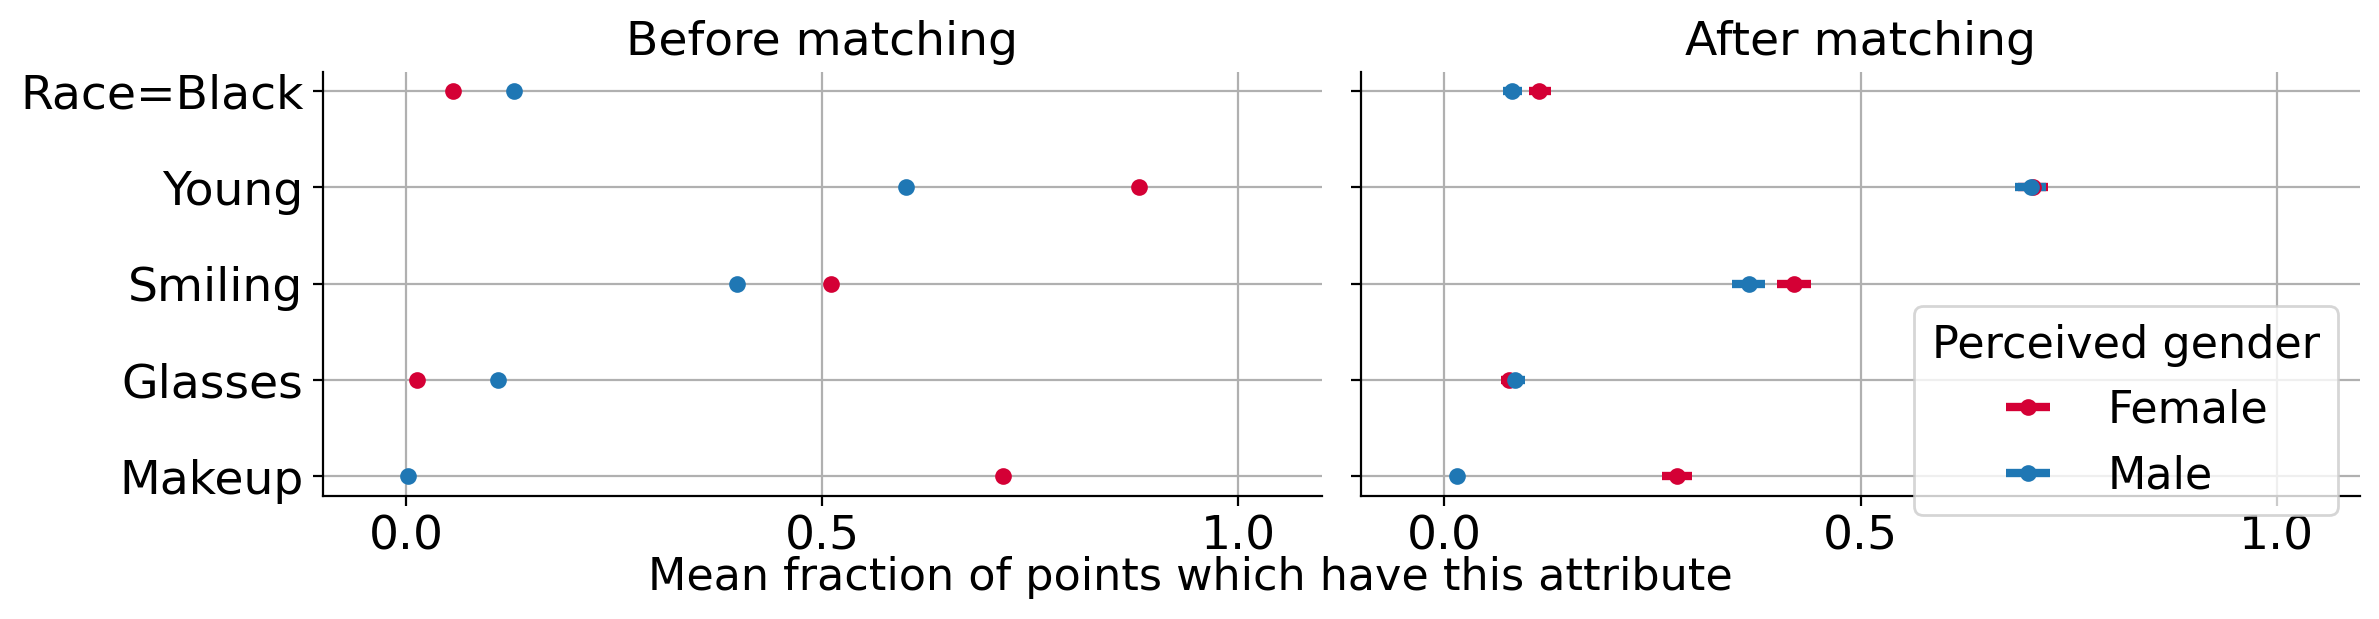

In [4]:
ds = [df, df_matched]
ks = [ #'yaw', 'pitch', 'roll',
         'Race=Black', 'young', 'smiling',
          'eyeglasses', 'makeup', 'gender',
          ][::-1] #, 'background_mean']
viz.plot_subgroup_mean_diffs(ds, ks, k_group, titles=['Before matching', 'After matching'])
util.savefig('means_matching_propensity')
plt.show()

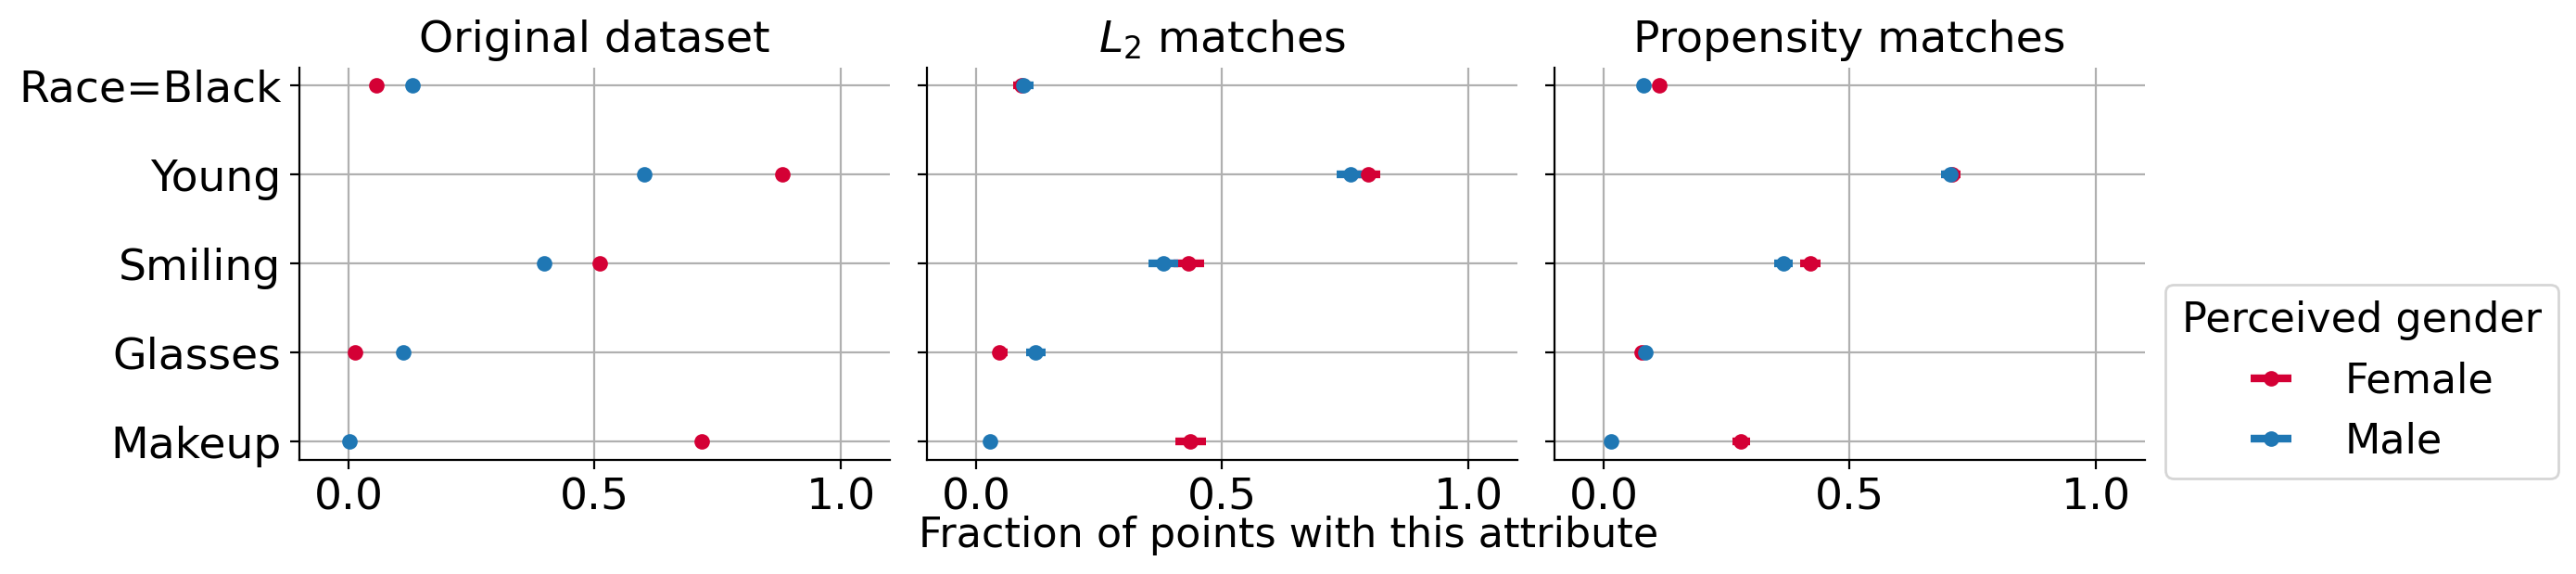

In [13]:
# plot propensity results next to the nearest neighbor matching results
NUM_MATCHES = 500
nearest_neighbor_matches_file = oj(DIR_PROCESSED, 'matches_gender_num=1200_facerecthresh=0.6.pkl')
df_matched_one_to_one, _ = matching.matches_to_df(pd.read_pickle(nearest_neighbor_matches_file), df, 'gender')
ds = [df, df_matched_one_to_one[:NUM_MATCHES], df_matched]
ks = [ #'yaw', 'pitch', 'roll',
         'Race=Black', 'young', 'smiling',
          'eyeglasses', 'makeup', 'gender', #'background_mean',
          ][::-1] #, 'background_mean']
viz.plot_subgroup_mean_diffs(ds, ks, k_group,
                             figsize=(14, 3),
                             titles=['Original dataset', '$L_2$ matches', 'Propensity matches'])
util.savefig('means_matching_full')
plt.show()

# intersectional mean diffs
**means across different intersectional subgroups**

/accounts/projects/vision/chandan/matching-with-gans/matching_benchmarking/viz.py:131: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(R, C, i + 1)
../util.py:17: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


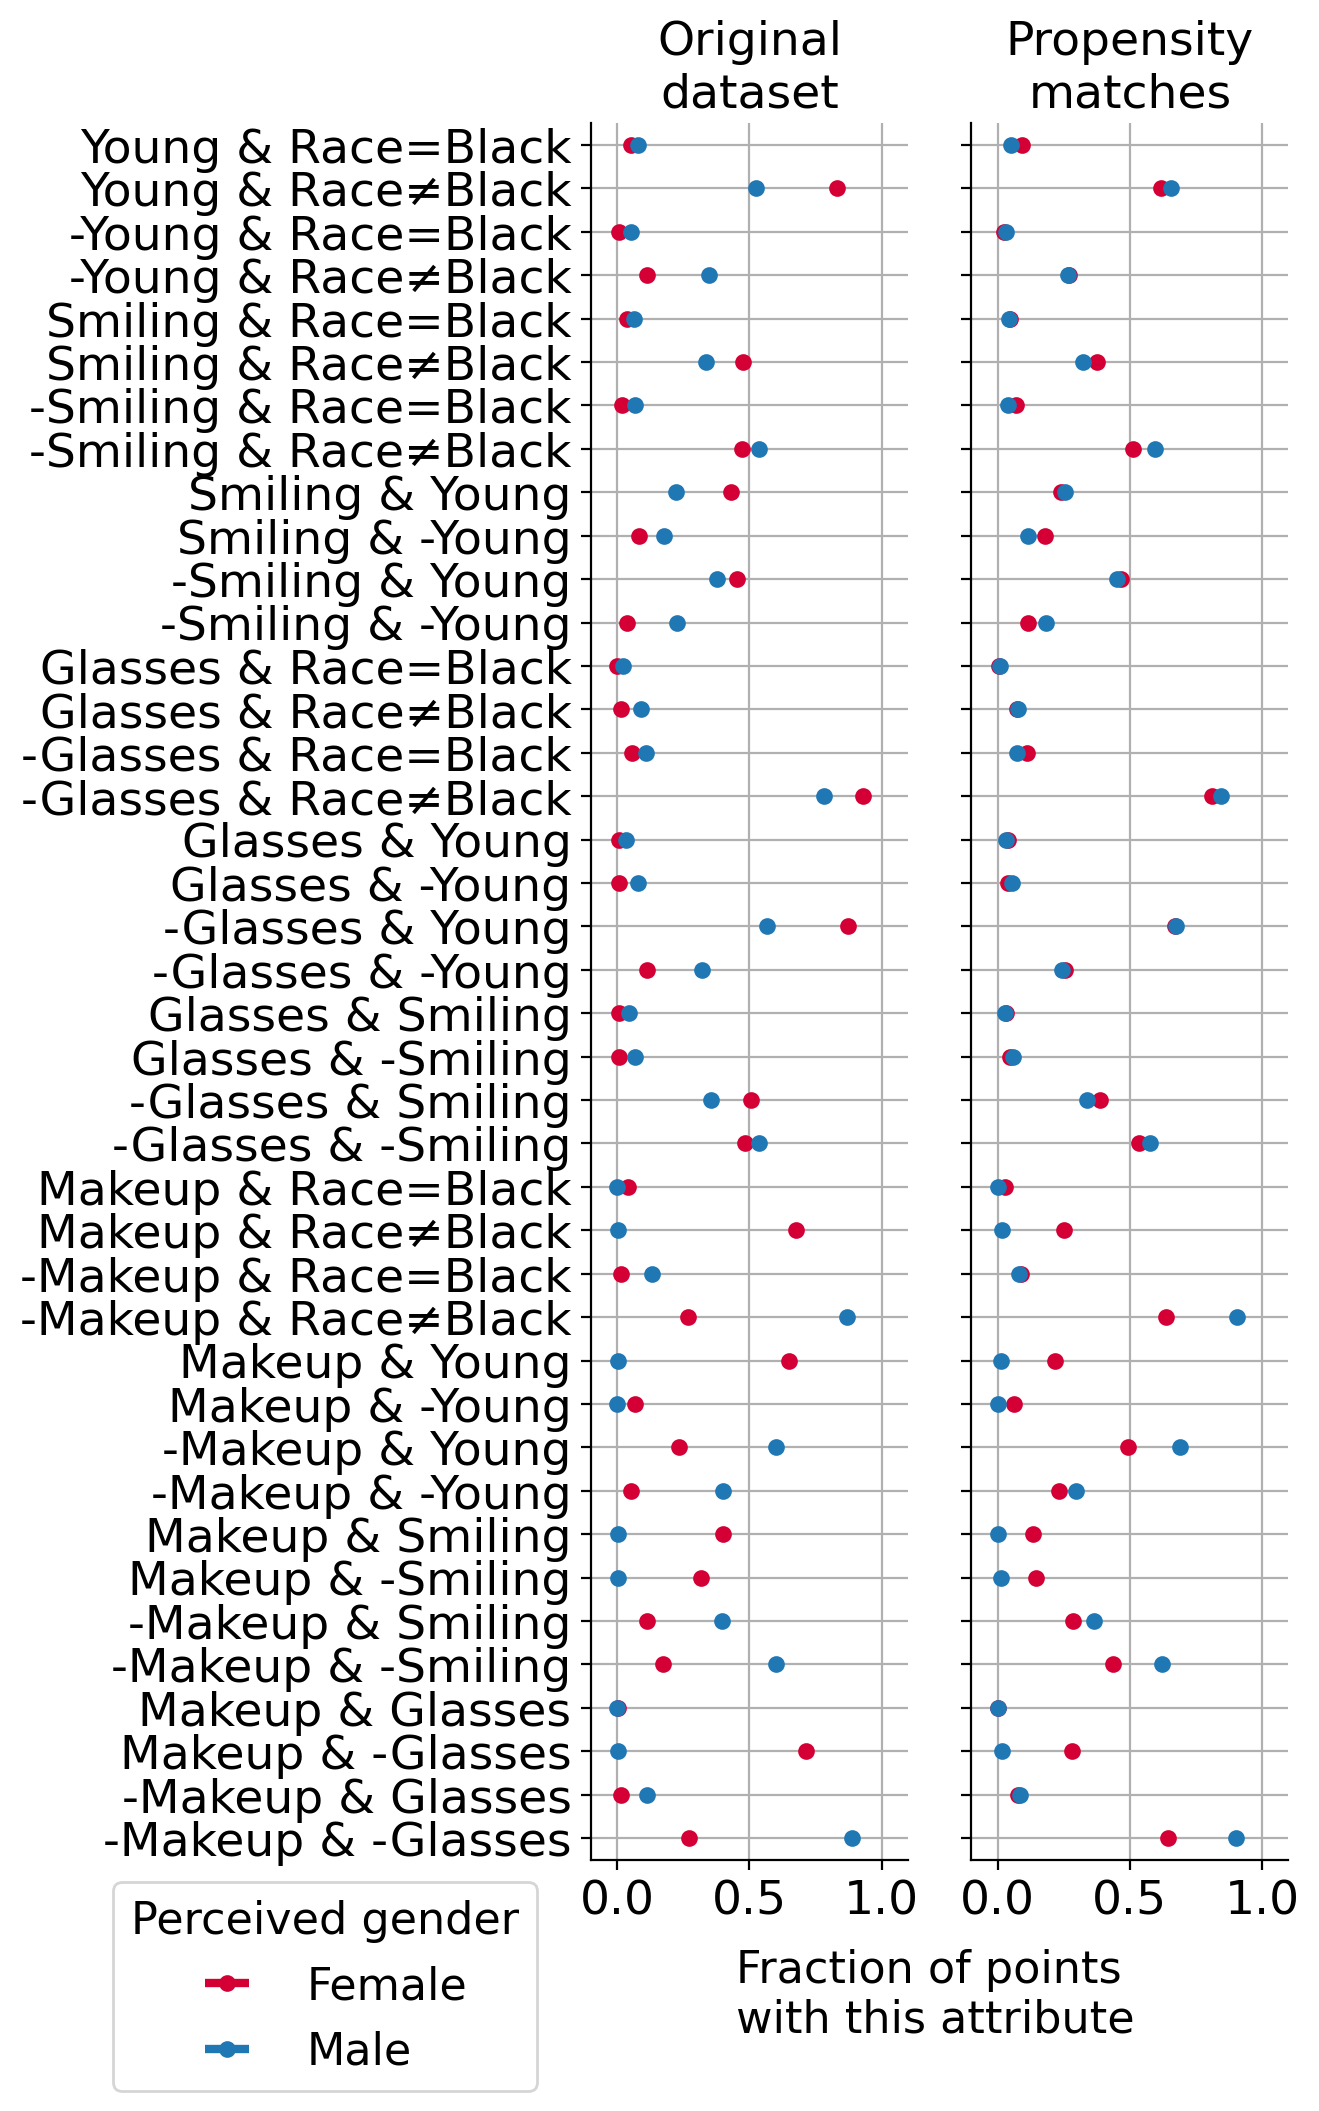

In [16]:
R, C = 1, 2
ks_init = ['Race=Black', 'young', 'smiling', 'eyeglasses', 'makeup', 'gender']
df_int, ks = matching.add_intersections(df, ks_init)
df_matched_int, ks = matching.add_intersections(df_matched, ks_init)
ds = [df_int, df_matched_int]
ks = ks[::-1] + ['gender']
viz.plot_subgroup_mean_diffs(ds, ks, k_group, figsize=(4.5, 11.5),
                             titles=['Original\ndataset', 'Propensity\nmatches'],
                             legend_loc='bottom') # (14, 11)
plt.figtext(-0.36, 0.9, 'Attribute pairs', fontsize=17)

util.savefig('means_intersectional_matching_propensity')
plt.show()